In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import glob
%matplotlib inline

## Camera calibration

In [2]:
from camera_calibrator import CameraCalibrator

In [3]:
camera_calibrator = CameraCalibrator(9, 6, images=glob.glob('camera_cal/calibration*.jpg'))
camera_calibrator.calibrate_camera()

Camera ready!


## Test the calibration

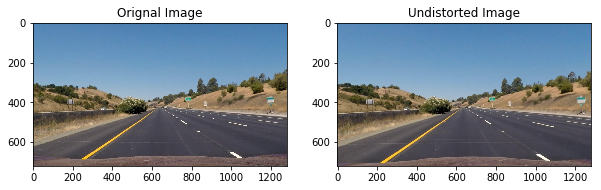

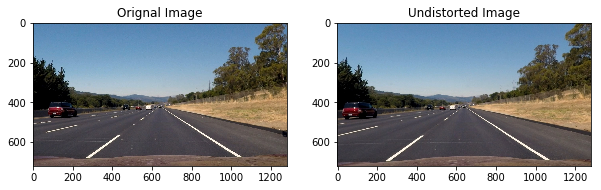

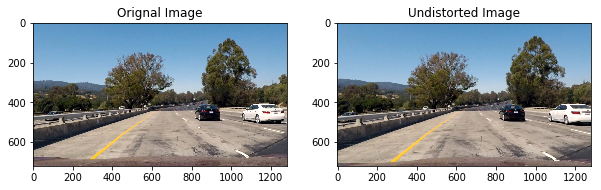

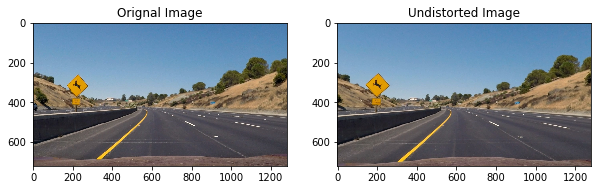

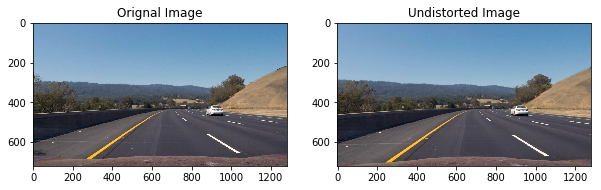

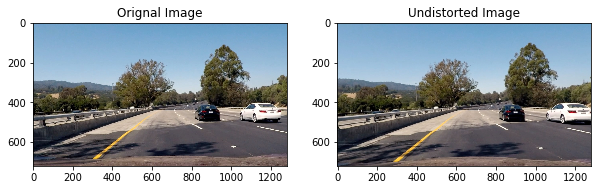

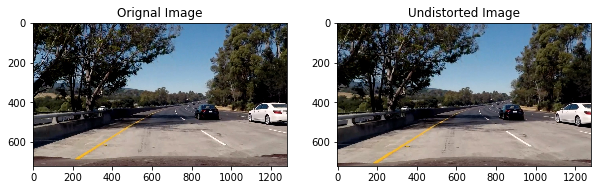

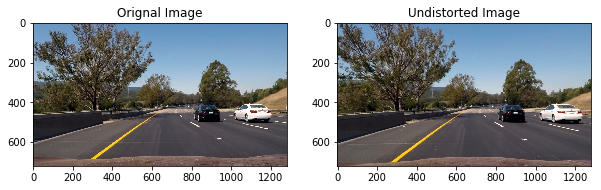

In [4]:
global test_images
test_images = glob.glob('test_images/*')
undistored_images = []
for path in test_images:
    img = mpimg.imread(path)
    undistored_images.append(camera_calibrator.undistort_image(img))
    camera_calibrator.plot_calibration_check(img)

# Pipeline 

In [5]:
from gradient_threshold import GradientThreshold
from color_threshold import ColorThreshold
from warp_image import WarpImage
from lane_lines import LaneLines
from util import get_color_gradient_combined

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import io
import base64

In [15]:
global src
#src=np.float32([[210, 720], [600, 460], [735, 460], [1160, 720]])
#dst=np.float32([[300, 720], [300, 0], [1100, 0], [1100, 720]])
src = np.array([[205, 720], [1120, 720], [754, 480], [540, 480]], np.float32)
dst = np.array([[205, 720], [1120, 720], [1120, 0], [205, 0]], np.float32)

In [16]:
gradient_threshold = GradientThreshold(kernel=3, thres_x=(20, 200), thres_y=(45, 150), 
                                       thres_mag=(35, 255), thres_dir=(0.7, 1.3))
color_threshold = ColorThreshold(thresh_H=(15, 80), thresh_S=(80, 255))
warp_image = WarpImage(src, dst)
lane = LaneLines()

In [17]:
def video_pipeline(img, test=False):
    # undistort the image
    undistored_image = camera_calibrator.undistort_image(img)
    
    # apply gradient and color threshold
    gt_result = gradient_threshold.get_gradient_threshold_combined(undistored_image)
    ct_result = color_threshold.get_color_threshold_combined(undistored_image)
    combined_image = get_color_gradient_combined(gt_result, ct_result)
    
    # warp the image
    binary_warped, Minv = warp_image.warp_image(combined_image)
  
    # Find the lane lines
    lane.lane_lines_full_search(combined_image, binary_warped)
    lane_lines = lane.translate_to_real_world_image(undistored_image, binary_warped, Minv)
    
    if test:
        return combined_image, gt_result, ct_result, binary_warped, lane, lane_lines
    else: 
        return lane_lines

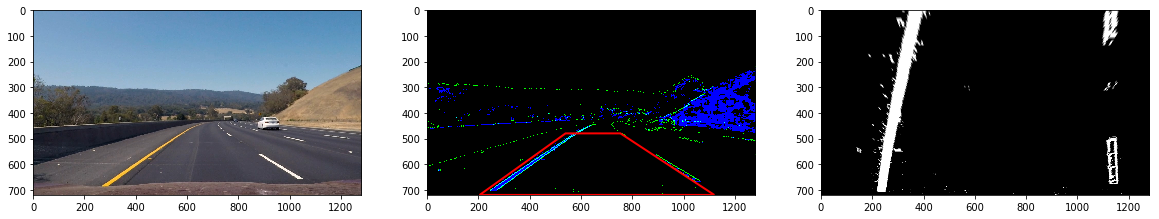

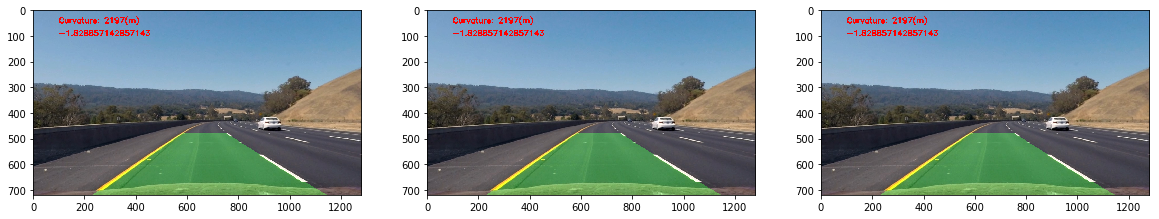

In [65]:
plot_pipeline_test = True
img_index = 4 # must be < 7

def test_video_pipeline():
    
    combined_images = []
    gt_results = [] 
    ct_results = []
    warps = []
    lanes = []
    pipeline_results = []
    
    for path in test_images:
        img = mpimg.imread(path)
        combined_image, gt_result, ct_result, warped, lane, lane_lines = video_pipeline(img, True)
        combined_images.append(combined_image)
        gt_results.append(gt_result)
        ct_results.append(ct_result)
        warps.append(warped)
        lanes.append(lane)
        pipeline_results.append(lane_lines)
        
        
    plt.close('all')
    fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
    img = mpimg.imread(test_images[img_index])
    ax1.imshow(img)
    stack_image = np.dstack(( np.zeros_like(gt_results[img_index]), gt_results[img_index], ct_results[img_index]))
    ax2.imshow(stack_image)
    rect = patches.Polygon(src, closed=True, fill=False, edgecolor='r', linewidth=2)
    ax2.add_patch(rect)
    ax3.imshow(warps[img_index], cmap='gray')
    fig2, ((ax4, ax5, ax6)) = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
    ax4.imshow(pipeline_results[img_index])
    ax5.imshow(pipeline_results[img_index])
    ax6.imshow(pipeline_results[img_index])
    
if plot_pipeline_test:
    test_video_pipeline()

In [39]:
def process_video(image):
    result = video_pipeline(image)
    return result

In [56]:
video_output = 'output_video/project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')

clip = clip1.fl_image(process_video)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|█▏        | 152/1261 [00:28<03:32,  5.22it/s]


 24%|██▍       | 303/1261 [00:56<02:55,  5.46it/s]


 36%|███▌      | 454/1261 [01:25<02:41,  5.00it/s]


 48%|████▊     | 605/1261 [01:56<02:15,  4.83it/s]


 60%|█████▉    | 756/1261 [02:27<01:41,  4.98it/s]


 72%|███████▏  | 907/1261 [02:57<01:08,  5.16it/s]


 84%|████████▍ | 1057/1261 [03:28<00:40,  5.03it/s]


 96%|█████████▌| 1205/1261 [03:58<00:11,  4.95it/s]


100%|█████████▉| 1260/1261 [04:09<00:00,  5.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 14min 52s, sys: 3.13 s, total: 14min 55s
Wall time: 4min 10s


In [63]:
video_output = 'output_video/challenge_video_output.mp4'
clip1 = VideoFileClip('challenge_video.mp4')

clip = clip1.fl_image(process_video)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



 32%|███▏      | 155/485 [00:30<01:04,  5.09it/s]


 64%|██████▎   | 309/485 [01:01<00:38,  4.54it/s]


 95%|█████████▌| 463/485 [01:33<00:04,  4.88it/s]


100%|██████████| 485/485 [01:38<00:00,  4.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 5min 43s, sys: 1.24 s, total: 5min 44s
Wall time: 1min 38s


In [64]:
video_output = 'output_video/harder_challenge_video_output.mp4'
clip1 = VideoFileClip('harder_challenge_video.mp4')

clip = clip1.fl_image(process_video)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4



 13%|█▎        | 152/1200 [00:34<03:54,  4.46it/s]


 25%|██▌       | 303/1200 [01:06<03:17,  4.54it/s]


 38%|███▊      | 454/1200 [01:39<02:39,  4.67it/s]


 50%|█████     | 605/1200 [02:11<02:00,  4.95it/s]


 63%|██████▎   | 756/1200 [02:43<01:34,  4.68it/s]


 76%|███████▌  | 907/1200 [03:14<00:58,  5.05it/s]


 88%|████████▊ | 1057/1200 [03:45<00:26,  5.33it/s]


100%|█████████▉| 1199/1200 [04:16<00:00,  4.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 14min 33s, sys: 2.68 s, total: 14min 35s
Wall time: 4min 17s


In [65]:
print('All video processed.')

All video processed.
